In [1]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="LangSmith now uses UUID v7", 
    category=UserWarning,
)

# Deep Agent for Research

## Overview 

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

Now, we can put everything we have learned together:

* We will use **TODOs** to keep track of tasks. 
* We will use **files** to store raw tool call results. 
* We will **delegate research tasks to sub-agents** for context isolation. 

## Search Tool 

We'll build a search tool that offloads raw contents to files and returns only a summary to the agent. This is a common pattern for long-running agent trajectories, [as we've seen with Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)! 

### Core Components

1. **Search Execution (`run_tavily_search`)**: Performs the actual web search using Tavily API with configurable parameters for results count and topic filtering.

2. **Content Summarization (`summarize_webpage_content`)**: Uses a lightweight model (GPT-4o-mini) to generate structured summaries of webpage content, producing both a descriptive filename and key learnings summary.

3. **Result Processing (`process_search_results`)**: Fetches full webpage content via HTTP, converts HTML to markdown using `markdownify`, and generates summaries for each result.

4. **Context Offloading (`tavily_search` tool)**: The main tool that:
   - Executes search and processes results
   - Saves full content to files in agent state (context offloading)
   - Returns only minimal summaries to the agent (prevents context spam)
   - Uses LangGraph `Command` to update both files and messages

5. **Strategic Thinking (`think_tool`)**: Provides a structured reflection mechanism for agents to analyze findings, assess gaps, and plan next steps in their research workflow.

This architecture solves the token efficiency problem by storing detailed search results in files while keeping the agent's working context minimal and focused.

<div style="background-color: #fff3b0; padding: 10px; border-radius: 4px;">
<b>Note:</b>  
The <code>create_react_agent</code> was moved from the LangGraph library to the LangChain library and renamed to <code>create_agent</code> in the 1.0 code release post-filming. There are slight changes to the imports and code to accommodate this. The video may display the previous configuration.
</div>

In [3]:
%%writefile ../src/deep_agents_from_scratch/research_tools.py
"""Research Tools.

This module provides search and content processing utilities for the research agent,
including web search capabilities and content summarization tools.
"""
import os
from datetime import datetime
import uuid, base64

import httpx
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from markdownify import markdownify
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing_extensions import Annotated, Literal

from deep_agents_from_scratch.prompts import SUMMARIZE_WEB_SEARCH
from deep_agents_from_scratch.state import DeepAgentState

# Summarization model 
summarization_model = init_chat_model(model="openai:gpt-4o-mini")
tavily_client = TavilyClient()

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    filename: str = Field(description="Name of the file to store.")
    summary: str = Field(description="Key learnings from the webpage.")

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

def run_tavily_search(
    search_query: str, 
    max_results: int = 1, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> dict:
    """Perform search using Tavily API for a single query.

    Args:
        search_query: Search query to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        Search results dictionary
    """
    result = tavily_client.search(
        search_query,
        max_results=max_results,
        include_raw_content=include_raw_content,
        topic=topic
    )

    return result

def summarize_webpage_content(webpage_content: str) -> Summary:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Summary object with filename and summary
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary_and_filename = structured_model.invoke([
            HumanMessage(content=SUMMARIZE_WEB_SEARCH.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        return summary_and_filename
        
    except Exception:
        # Return a basic summary object on failure
        return Summary(
            filename="search_result.md",
            summary=webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content
        )

def process_search_results(results: dict) -> list[dict]:
    """Process search results by summarizing content where available.
    
    Args:
        results: Tavily search results dictionary
        
    Returns:
        List of processed results with summaries
    """
    processed_results = []

    # Create a client for HTTP requests
    HTTPX_CLIENT = httpx.Client()
    
    for result in results.get('results', []):
        
        # Get url 
        url = result['url']
        
        # Read url
        response = HTTPX_CLIENT.get(url)

        if response.status_code == 200:
            # Convert HTML to markdown
            raw_content = markdownify(response.text)
            summary_obj = summarize_webpage_content(raw_content)
        else:
            # Use Tavily's generated summary
            raw_content = result.get('raw_content', '')
            summary_obj = Summary(
                filename="URL_error.md",
                summary=result.get('content', 'Error reading URL; try another search.')
            )
        
        # uniquify file names
        uid = base64.urlsafe_b64encode(uuid.uuid4().bytes).rstrip(b"=").decode("ascii")[:8]
        name, ext = os.path.splitext(summary_obj.filename)
        summary_obj.filename = f"{name}_{uid}{ext}"

        processed_results.append({
            'url': result['url'],
            'title': result['title'],
            'summary': summary_obj.summary,
            'filename': summary_obj.filename,
            'raw_content': raw_content,
        })
    
    return processed_results

@tool(parse_docstring=True)
def tavily_search(
    query: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
    max_results: Annotated[int, InjectedToolArg] = 1,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> Command:
    """Search web and save detailed results to files while returning minimal context.

    Performs web search and saves full content to files for context offloading.
    Returns only essential information to help the agent decide on next steps.

    Args:
        query: Search query to execute
        state: Injected agent state for file storage
        tool_call_id: Injected tool call identifier
        max_results: Maximum number of results to return (default: 1)
        topic: Topic filter - 'general', 'news', or 'finance' (default: 'general')

    Returns:
        Command that saves full results to files and provides minimal summary
    """
    # Execute search
    search_results = run_tavily_search(
        query,
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    ) 

    # Process and summarize results
    processed_results = process_search_results(search_results)
    
    # Save each result to a file and prepare summary
    files = state.get("files", {})
    saved_files = []
    summaries = []
    
    for i, result in enumerate(processed_results):
        # Use the AI-generated filename from summarization
        filename = result['filename']
        
        # Create file content with full details
        file_content = f"""# Search Result: {result['title']}

**URL:** {result['url']}
**Query:** {query}
**Date:** {get_today_str()}

## Summary
{result['summary']}

## Raw Content
{result['raw_content'] if result['raw_content'] else 'No raw content available'}
"""
        
        files[filename] = file_content
        saved_files.append(filename)
        summaries.append(f"- {filename}: {result['summary']}...")
    
    # Create minimal summary for tool message - focus on what was collected
    summary_text = f"""🔍 Found {len(processed_results)} result(s) for '{query}':

{chr(10).join(summaries)}

Files: {', '.join(saved_files)}
💡 Use read_file() to access full details when needed."""

    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(summary_text, tool_call_id=tool_call_id)
            ],
        }
    )

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    - How complex is the question: Have I reached the number of search limits?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps

    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

Overwriting ../src/deep_agents_from_scratch/research_tools.py


## Deep Agent

Now, we can just apply all of our prior learnings: 

* We'll give the researcher a `think_tool` and our `search_tool` above.
* We'll give our parent agent file tools, a `think_tool`, and a `task` tool. 

In [4]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
#from langgraph.prebuilt import create_react_agent
from langchain.agents import create_agent
from utils import show_prompt, stream_agent

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.prompts import (
    FILE_USAGE_INSTRUCTIONS,
    RESEARCHER_INSTRUCTIONS,
    SUBAGENT_USAGE_INSTRUCTIONS,
    TODO_USAGE_INSTRUCTIONS,
)
from deep_agents_from_scratch.research_tools import tavily_search, think_tool, get_today_str
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool
from deep_agents_from_scratch.todo_tools import write_todos, read_todos

# Create agent using create_react_agent directly
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Tools
sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, read_todos, think_tool]

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": ["tavily_search", "think_tool"],
}

# Create task tool to delegate tasks to sub-agents
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

delegation_tools = [task_tool]
all_tools = sub_agent_tools + built_in_tools + delegation_tools  # search available to main agent for trivial cases

# Build prompt
SUBAGENT_INSTRUCTIONS = SUBAGENT_USAGE_INSTRUCTIONS.format(
    max_concurrent_research_units=max_concurrent_research_units,
    max_researcher_iterations=max_researcher_iterations,
    date=datetime.now().strftime("%a %b %-d, %Y"),
)

In [5]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 1-2 search tool calls maximum                                                        │
│  - **Normal queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Very Complex queries**: Use up to 5 search tool calls maximum                                              │
│  - **Always stop**: After 5 search tool calls if you c

In [6]:
INSTRUCTIONS = (
    "# TODO MANAGEMENT\n"
    + TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# FILE SYSTEM USAGE\n"
    + FILE_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# SUB-AGENT DELEGATION\n"
    + SUBAGENT_INSTRUCTIONS
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # TODO MANAGEMENT                                                                                              │
│  Based upon the user's request:                                                                                 │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # FILE SYSTEM USAGE                                                                                            │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Research**: Proceed with research. The search tool will write files.                                      │
│  4. **Read**: Once you are satisfied with the collected sources, read the files and use them to answer the      │
│  user's question directly.                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # SUB-AGENT DELEGATION                                                                                         │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                               

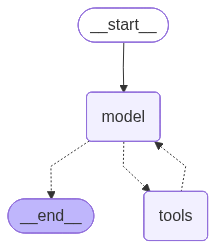

In [7]:
# Create agent
agent = create_agent(  #updated 1.0
    model, all_tools, system_prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [8]:
from utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get a comprehensive overview of Model Context Protocol (MCP). Let me start by creating a research │
│ plan and then delegate the research task.                                                                       │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save user request to file system for reference",                                              │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, key features, architecture, use  │
│ cases, and current status",                                                                                     │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Compile comprehensive overview based on research findings",                                   │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01TfYu7JNYCKxsBsdzoKxBar                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save user request to file system for reference', 'status': 'pending'},       │
│ {'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features, architecture, use       │
│ cases, and current status', 'status': 'pending'}, {'content': 'Compile comprehensive overview based on research │
│ findings', 'status': 'pending'}]                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: toolu_01PTrizBXhSCm7Vd2UVWwwuf                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "user_request.md",                                                                               │
│   "content": "# User Request\n\nGive me an overview of Model Context Protocol (MCP).\n\n## Research             │
│ Objective\nProvide a comprehensive overview covering:\n- Definition and purpose of MCP\n- Key features and      │
│ capabilities\n- Architecture and technical details\n- Use cases and applications\n- Current development         │
│ status\n- Relationship to other protocols/standards"                                                            │
│ }                                                                                                               │
│    ID: toolu_01EYSoBGDGt1ZmrQdVGmfwQu                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file user_request.md                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: toolu_01Jaicn3ZFrsx7ENunqkuQZ3                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. ⏳ Save user request to file system for reference (pending)                                                  │
│ 2. ⏳ Research Model Context Protocol (MCP) - definition, purpose, key features, architecture, use cases, and   │
│ current status (pending)                                                                                        │
│ 3. ⏳ Compile comprehensive overview based on research findings (pending)                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save user request to file system for reference",                                              │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, key features, architecture, use  │
│ cases, and current status",                                                                                     │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Compile comprehensive overview based on research findings",                                   │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01BRZ94kDhhTAMKACVgFY5Vt                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save user request to file system for reference', 'status': 'completed'},     │
│ {'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features, architecture, use       │
│ cases, and current status', 'status': 'in_progress'}, {'content': 'Compile comprehensive overview based on      │
│ research findings', 'status': 'pending'}]                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now I'll delegate the research task to a specialized research agent to gather comprehensive information about   │
│ Model Context Protocol.                                                                                         │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research Model Context Protocol (MCP) comprehensively. I need detailed information covering:  │
│ 1) What MCP is and its core purpose/goals, 2) Key technical features and capabilities, 3) Architecture and how  │
│ it works, 4) Primary use cases and applications, 5) Current development status and adoption, 6) Who developed   │
│ it and when, 7) How it relates to other protocols or standards in the AI/ML space. Focus on official sources,   │
│ documentation, and recent developments.",                                                                       │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: toolu_01Y4GAAX3CQoGDaNNyt7wZbF                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my comprehensive research, here's detailed information about the Model Context Protocol (MCP):         │
│                                                                                                                 │
│ ## 1. What MCP Is and Its Core Purpose/Goals                                                                    │
│                                                                                                                 │
│ The Model Context Protocol (MCP) is an **open standard** introduced by Anthropic that standardizes interactions │
│ between Large Language Models (LLMs) and external applications, systems, and data sources. Its core purpose is  │
│ to enable **dynamic, two-way communication** between AI applications and external services, allowing LLMs to:   │
│                                                                                                                 │
│ - Access real-time data from external sources                                                                   │
│ - Perform actions through external tools and applications                                                       │
│ - Maintain structured context management                                                                        │
│ - Reduce hallucinations by connecting to trusted data sources                                                   │
│ - Enhance accuracy and automation capabilities                                                                  │
│                                                                                                                 │
│ The protocol focuses on **structured context management** and aims to reduce the complexity of connecting LLMs  │
│ to various external tools and services.                                                                         │
│                                                                                                                 │
│ ## 2. Key Technical Features and Capabilities                                                                   │
│                                                                                                                 │
│ MCP offers several important technical features:                                                                │
│                                                                                                                 │
│ - **Structured Capabilities**: Exposes tools, resources, and prompts through predictable, schema-driven         │
│ interfaces                                                                                                      │
│ - **Standardization**: Provides consistent APIs designed for ease of use and integration                        │
│ - **Extensibility**: Supports custom implementations for specific use cases                                     │
│ - **Security Framework**: Implements security best practices including:                                         │
│   - Least privilege access controls                                                                             │
│   - Role-Based Access Control (RBAC) and Attribute-Based Access Control (ABAC)                                  │
│   - Short-lived authentication mechanisms (mTLS, OAuth 2.1)                                                     │
│   - Input/output validation against strict schemas                                                              │
│   - Traceable audit logging                                                                                     │
│ - **Schema-Driven Interface**: Ensures predictable and reliable interactions                                    │
│ - **Real-time Data Access**: Enables LLMs to work with current, dynamic information                             │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The research agent has provided excellent comprehensive information about Model Context        │
│ Protocol (MCP). The findings cover all the key aspects I requested:\n\n1. ✅ Definition and core purpose - MCP  │
│ is an open standard by Anthropic for standardizing LLM interactions with external systems\n2. ✅ Key technical  │
│ features - structured capabilities, security framework, schema-driven interfaces\n3. ✅ Architecture -          │
│ server-client model with tools, resources, prompts, and transport layers\n4. ✅ Use cases - Claude Desktop      │
│ integration, database connectivity, API integration, enterprise applications\n5. ✅ Development status - Very   │
│ new (November 2024), early adoption phase\n6. ✅ Developer info - Created by Anthropic in November 2024 as an   │
│ open standard\n7. ✅ Relationship to other protocols - Compared to OpenAI API, LangChain, and agent             │
│ frameworks\n\nThe information appears comprehensive and current. The research agent found official sources and  │
│ provided detailed technical information. I now have sufficient information to compile a complete overview for   │
│ the user. I should mark the research task as completed and move to the final compilation step."                 │
│ }                                                                                                               │
│    ID: toolu_01C4CwcBTfqWTHrLEq4BDjFD                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The research agent has provided excellent comprehensive information about Model Context    │
│ Protocol (MCP). The findings cover all the key aspects I requested:                                             │
│                                                                                                                 │
│ 1. ✅ Definition and core purpose - MCP is an open standard by Anthropic for standardizing LLM interactions     │
│ with external systems                                                                                           │
│ 2. ✅ Key technical features - structured capabilities, security framework, schema-driven interfaces            │
│ 3. ✅ Architecture - server-client model with tools, resources, prompts, and transport layers                   │
│ 4. ✅ Use cases - Claude Desktop integration, database connectivity, API integration, enterprise applications   │
│ 5. ✅ Development status - Very new (November 2024), early adoption phase                                       │
│ 6. ✅ Developer info - Created by Anthropic in November 2024 as an open standard                                │
│ 7. ✅ Relationship to other protocols - Compared to OpenAI API, LangChain, and agent frameworks                 │
│                                                                                                                 │
│ The information appears comprehensive and current. The research agent found official sources and provided       │
│ detailed technical information. I now have sufficient information to compile a complete overview for the user.  │
│ I should mark the research task as completed and move to the final compilation step.                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: toolu_01DHg6A4MFJVXkpCvLA6xPD3                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. ✅ Save user request to file system for reference (completed)                                                │
│ 2. 🔄 Research Model Context Protocol (MCP) - definition, purpose, key features, architecture, use cases, and   │
│ current status (in_progress)                                                                                    │
│ 3. ⏳ Compile comprehensive overview based on research findings (pending)                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save user request to file system for reference",                                              │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, key features, architecture, use  │
│ cases, and current status",                                                                                     │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Compile comprehensive overview based on research findings",                                   │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_0153D8kmD1PgAj9yV5UumZDn                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save user request to file system for reference', 'status': 'completed'},     │
│ {'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features, architecture, use       │
│ cases, and current status', 'status': 'completed'}, {'content': 'Compile comprehensive overview based on        │
│ research findings', 'status': 'in_progress'}]                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now I'll compile a comprehensive overview of Model Context Protocol (MCP) based on the research findings:       │
│                                                                                                                 │
│ # Model Context Protocol (MCP) - Overview                                                                       │
│                                                                                                                 │
│ ## What is MCP?                                                                                                 │
│                                                                                                                 │
│ **Model Context Protocol (MCP)** is an open standard introduced by Anthropic in November 2024 that standardizes │
│ how Large Language Models (LLMs) interact with external applications, systems, and data sources. Think of it as │
│ a universal "language" that allows AI models to communicate with and control external tools in a structured,    │
│ secure way.                                                                                                     │
│                                                                                                                 │
│ ## Core Purpose & Goals                                                                                         │
│                                                                                                                 │
│ MCP addresses a fundamental challenge in AI: **connecting LLMs to real-world data and tools**. Its primary      │
│ goals are to:                                                                                                   │
│                                                                                                                 │
│ - Enable **dynamic, two-way communication** between AI and external systems                                     │
│ - Provide **real-time access** to current data (reducing hallucinations)                                        │
│ - **Standardize** how different AI applications connect to tools and services                                   │
│ - Enhance AI **accuracy and automation** capabilities through trusted data sources                              │
│ - Simplify the complexity of building AI integrations                                                           │
│                                                                                                                 │
│ ## Key Technical Features                                                                                       │
│                                                                                                                 │
│ ### 🔧 **Structured Capabilities**                                                                              │
│ - **Tools**: Functional capabilities that can be executed by the AI                                             │
│ - **Resources**: Data sources that can be accessed and queried                                                  │
│ - **Prompts**: Structured prompt templates for consistent interactions                                          │
│                                                                                                                 │
│ ### 🛡️ **Security Framework**                                                                                    │
│ - **Least privilege access** controls                                                                           │
│ - **Role-Based Access Control (RBAC)** and **Attribute-Based Access Control (ABAC)**                            │
│ - **Short-lived authentication** (mTLS, OAuth 2.1)                                                              │
│ - **Input/output validation** against strict schemas   

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save user request to file system for reference', 'status': 'completed'},     │
│ {'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features, architecture, use       │
│ cases, and current status', 'status': 'completed'}, {'content': 'Compile comprehensive overview based on        │
│ research findings', 'status': 'completed'}]                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I've provided you with a comprehensive overview of Model Context Protocol (MCP). Here are the key takeaways:    │
│                                                                                                                 │
│ **MCP is Anthropic's brand-new open standard** (released November 2024) that standardizes how AI models         │
│ interact with external systems. It's designed to solve the challenge of connecting LLMs to real-world data and  │
│ tools in a secure, structured way.                                                                              │
│                                                                                                                 │
│ **Key highlights:**                                                                                             │
│ - 🆕 **Very recent**: Just released in November 2024                                                            │
│ - 🔒 **Security-focused**: Built-in enterprise-grade security features                                          │
│ - 🏗️ **Standardized**: Creates common protocols for AI-external system interactions                              │
│ - 🔧 **Practical**: Already integrated with Claude Desktop, with growing ecosystem                              │
│ - 🌐 **Open**: Vendor-neutral standard, not proprietary to Anthropic                                            │
│                                                                                                                 │
│ The protocol is particularly significant because it addresses real enterprise needs around AI integration while │
│ being designed with security and standardization as core principles from the start, rather than as              │
│ afterthoughts.                                                                                                  │
│                                                                                                                 │
│ Since it's so new, adoption is still in early stages, but it's positioned to become an important foundational   │
│ technology as organizations increasingly look to integrate AI into their existing systems and workflows.        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/3a389ec6-8e6e-4f9e-9a82-0d0a9569e6f8/r
<!-- https://smith.langchain.com/public/1df7a10e-1465-499c-a3e0-86c1d5429324/r -->

## Using the Deep Agent Package

Now you understand the underlying patterns! 

You can [use the `deepagents` package](
https://github.com/hwchase17/deepagents) as a simple abstraction:

* It include the file system tools
* It includes the todo tool
* It includes the task tool

You only need to supply the sub-agent and any tools you want the sub-agent to use.

In [11]:
from deepagents import create_deep_agent
# updated since filming

# Create research sub-agent
research_sub_agent_2 = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": [tavily_search, think_tool],
}


agent = create_deep_agent(  # updated 
    tools=sub_agent_tools,
    system_prompt=INSTRUCTIONS,
    subagents=[research_sub_agent_2],
    model=model,
)

# Show the agent
#display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [12]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an very brief overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

/Users/geoffladwig/Documents/Github/TestV1/deep-agents-from-scratch/.venv/lib/python3.13/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `general-fields` - serialized value may not be as expected [field_name='files', input_value='# Search Result: What is...504.0245/v1),\xa02025\n', input_type=str])
  return self.__pydantic_serializer__.to_python(
/Users/geoffladwig/Documents/Github/TestV1/deep-agents-from-scratch/.venv/lib/python3.13/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `general-fields` - serialized value may not be as expected [field_name='files', input_value='# Search Result: What is...504.0245/v1),\xa02025\n', input_type=str])
  PydanticSerializationUnexpectedValue(Expected `general-fields` - serialized value may not be as expected [field_name='files', input_value='# Search Result: What is...e](/badges/hipaa.svg)\n',

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an very brief overview of Model Context Protocol (MCP).                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get a brief overview of Model Context Protocol (MCP). Let me research this for you.               │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) to gather key information",                             │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Provide a very brief overview based on research findings",                                    │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01Em2sRLyUB1wfE3ufyterdH                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) to gather key information', 'status':  │
│ 'in_progress'}, {'content': 'Provide a very brief overview based on research findings', 'status': 'pending'}]   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research Model Context Protocol (MCP) and provide a comprehensive overview covering: what it  │
│ is, its purpose, key features, how it works, who developed it, and its main use cases. Focus on gathering       │
│ factual information from reliable sources about this protocol.",                                                │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: toolu_01Sboxj6LEGm6N9GQMVSUkbG                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my research, here's a comprehensive overview of the Model Context Protocol (MCP):                      │
│                                                                                                                 │
│ ## What is the Model Context Protocol (MCP)?                                                                    │
│                                                                                                                 │
│ The Model Context Protocol (MCP) is a standardization layer that enhances communication between AI applications │
│ and external tools and data sources. It serves as an open standard protocol designed to enable AI agents to be  │
│ context-aware and effectively integrate multiple services without requiring manual coding for each individual   │
│ integration.                                                                                                    │
│                                                                                                                 │
│ ## Developer                                                                                                    │
│                                                                                                                 │
│ MCP was developed by **Anthropic**, the AI safety company behind Claude.                                        │
│                                                                                                                 │
│ ## Purpose and Goals                                                                                            │
│                                                                                                                 │
│ The primary purpose of MCP is to:                                                                               │
│ - **Standardize communication** between AI models and external tools/data sources                               │
│ - **Streamline API communication** by replacing custom API integrations                                         │
│ - **Reduce development overhead** and enhance developer experience                                              │
│ - **Enable dynamic tool discovery** and simplified context management                                           │
│ - **Create a flexible, scalable architecture** for AI tool integration                                          │
│                                                                                                                 │
│ ## Key Features                                                                                                 │
│                                                                                                                 │
│ 1. **Standardized Communication**: Provides a unified way for AI models to interact with external systems       │
│ 2. **Dynamic Tool Discovery**: Allows AI agents to discover and utilize tools on-the-fly                        │
│ 3. **Simplified Context Management**: Streamlines how context is shared and managed across different services   │
│ 4. **Real-time Notifications**: Supports dynamic updates and real-time interactions                             │
│ 5. **Flexible Architecture**: Supports both local and remote server implementations                             │
│ 6. **Open Standard**: Designed as an open protocol to encourage widespread adoption                             │
│                                                                                                                 │
│ ## How It Works                                                                                                 │
│                                                                                                                 │
│ MCP operates on a **client-server architecture** with t

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) to gather key information",                             │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Provide a very brief overview based on research findings",                                    │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01HReVF16cWADY6Cx56UKXcc                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) to gather key information', 'status':  │
│ 'completed'}, {'content': 'Provide a very brief overview based on research findings', 'status': 'in_progress'}] │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ## Model Context Protocol (MCP) - Brief Overview                                                                │
│                                                                                                                 │
│ **Model Context Protocol (MCP)** is an open standard developed by **Anthropic** that standardizes communication │
│ between AI applications and external tools/data sources.                                                        │
│                                                                                                                 │
│ **Key Points:**                                                                                                 │
│ - **Purpose**: Eliminates the need for custom API integrations by providing a unified protocol for AI-tool      │
│ communication                                                                                                   │
│ - **Architecture**: Client-server model built on JSON-RPC 2.0                                                   │
│ - **Core Components**: Tools (functions), Resources (data), and Prompts (templates)                             │
│ - **Benefits**: Reduces development complexity, enables dynamic tool discovery, and improves context management │
│ - **Use Cases**: IT automation, recruiting, finance operations, vendor management, and real-time decision       │
│ making                                                                                                          │
│                                                                                                                 │
│ **Bottom Line**: MCP simplifies how AI agents connect to external services, making it easier to build           │
│ context-aware AI applications without writing custom integrations for each tool.                                │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) to gather key information",                             │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Provide a very brief overview based on research findings",                                    │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01UgEkB3HDBXLH19EYSSWzNF                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) to gather key information', 'status':  │
│ 'completed'}, {'content': 'Provide a very brief overview based on research findings', 'status': 'completed'}]   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/1d626d81-a102-4588-a2fb-cab40a7271f1/r
<!-- https://smith.langchain.com/public/1ae2d7f6-f901-4ebd-b6c3-6657a55f88ae/r -->